# Image Processing Cheatsheet

Notebook of snippets, tips, and tricks for working with images in Numpy and Pytorch

* https://github.com/soumith/the-incredible-pytorch
* https://github.com/pytorch/examples/blob/master/dcgan/main.py
* https://github.com/soumith/ganhacks
* https://github.com/alexis-jacq/Pytorch-Tutorials/blob/master/Neural_Style.ipynb
* http://www.scipy-lectures.org/advanced/image_processing/

# Topics

* Display Grid of Images/Tensors/Arrays
* Normalize with the Min/Max to put the values within a specific range YOU define?
* Data Augmentation (Scale, Resize, Random flips, crops)
* Blob Detection
* Pytorch Datasets
* Pytorch Data loaders

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_img_utils
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from PIL import Image
import imp
import os
import sys
import math
import time
import random
import shutil
import cv2
import scipy.misc
from glob import glob

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

%matplotlib inline

## Pillow SIMD

* https://pillow.readthedocs.io/en/4.0.x
* https://github.com/uploadcare/pillow-simd
* https://python-pillow.org/pillow-perf/
* Pillow Original - 15.2 seconds per 4000 images
* Pillow-SIMD - 12.7 secs per 4000 images
How much faster is SIMD than Original?
* http://math.stackexchange.com/questions/1227389/what-is-the-difference-between-faster-by-factor-and-faster-by-percent
* (15.2 - 12.7) / 12.7 = ~20% faster
* 20% speedup

In [2]:
# Force uninstall old version, then install pillow-simd\n#$ pip uninstall pillow
#$ CC=\"cc -mavx2\" pip install -U --force-reinstall pillow-simd
#12 seconds per 4000 images
import PIL
print (PIL.PILLOW_VERSION)

4.0.0.post0


# File Management

In [3]:
DATA_PATH = '/media/bfortuner/bigguy/data/animecolor/'
IMAGES_PATH = DATA_PATH + 'imgs/'
WEIGHTS_PATH = DATA_PATH + 'weights/'
RESULTS_PATH = DATA_PATH + 'results/'

In [4]:
def get_paths_to_files(dir_path):
    filepaths = []
    fnames = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames)
        fnames.extend([f for f in filenames])
    return filepaths, fnames

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)[0]
    return filepaths[random.randrange(len(filepaths))]

# Converting Between Types

Imported PIL images has values between 0 and 255. Transformed into torch tensors, their values are between 0 and 1. This is an important detail: neural networks from torch library are trained with 0-1 tensor image. If you try to feed the networks with 0-255 tensor images the activated feature maps will have no sens.

In [5]:
img_path = get_random_image_path(IMAGES_PATH)

In [6]:
# PIL to numpy
pil_img = Image.open(img_path)
print("PIL",pil_img.size,type(pil_img)) #hides number of channels (3)
np_from_pil = np.array(pil_img)
print("NumpyFromPIL", np_from_pil.shape, type(np_from_pil)) #Channels is visible as last param (3)

# Numpy to PIL
# http://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap
print(np_from_pil.shape, np_from_pil.mean(), np_from_pil.min(), np_from_pil.max(), np_from_pil.std())
pil_from_numpy = Image.fromarray(np_from_pil)
print("PILfromNumpy", pil_from_numpy.size, type(pil_from_numpy))

## PIL to Tensor
tns = transforms.ToTensor()(pil_img)
print("Tensor", tns.size(), type(tns))

# Tensor to PIL (also handles numpy arrays)
pil_from_tensor = transforms.ToPILImage()(tns)
print("PilFromTensor", pil_from_tensor.size, type(pil_from_tensor))

# Tensor to Numpy
np_from_tensor = tns.numpy()
print("NumpyFromTensor", np_from_tensor.shape, type(np_from_tensor)) #Channel dim order now in Pytorch language

# Numpy to Tensor
np_to_tensor = torch.from_numpy(np_from_tensor)
print("NumpyToTensor", np_to_tensor.size(), type(np_to_tensor))


PIL (511, 512) <class 'PIL.JpegImagePlugin.JpegImageFile'>
NumpyFromPIL (512, 511, 3) <class 'numpy.ndarray'>
(512, 511, 3) 200.49754235 0 255 54.4740488574
PILfromNumpy (511, 512) <class 'PIL.Image.Image'>
Tensor torch.Size([3, 512, 511]) <class 'torch.FloatTensor'>
PilFromTensor (511, 512) <class 'PIL.Image.Image'>
NumpyFromTensor (3, 512, 511) <class 'numpy.ndarray'>
NumpyToTensor torch.Size([3, 512, 511]) <class 'torch.FloatTensor'>


In [7]:
# Cool method that handles both Numpy and Tensor --> to PIL conversion
def unload_img_tensor_or_array(img_tensor_or_np_arr):
    """Converts
    torch.*Tensor of shape C x H x W  
        OR
    numpy ndarray of shape H x W x C 
    to PIL.Image while preserving value range
    """
    return transforms.ToPILImage()(img_tensor_or_np_arr)

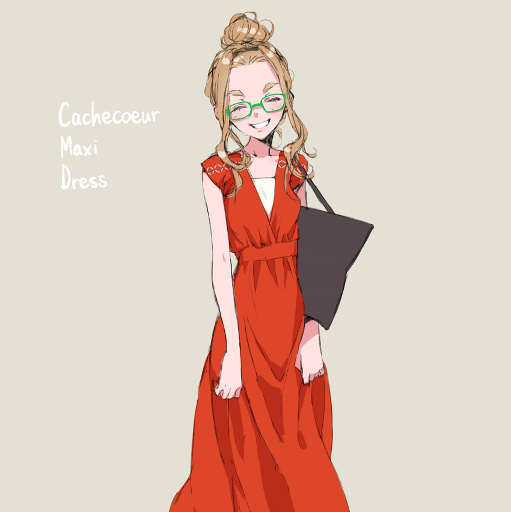

In [8]:
pil_out_t = unload_img_tensor_or_array(tns)
pil_out_n = unload_img_tensor_or_array(np_from_pil)
pil_out_n

# Image Loading

In [9]:
img_path = get_random_image_path(IMAGES_PATH)

In [10]:
def load_img_as_pil(img_path):
    return Image.open(img_path)

def load_img_as_np_arr(img_path):
    return scipy.misc.imread(img_path) #scipy

def load_img_as_tensor(img_path):
    pil_image = Image.open(img_path)
    return transforms.ToTensor()(pil_image)

def load_img_as_tensor_w_transforms(img_path, transforms):
    pil_image = Image.open(img_path)
    return transforms(pil_image) #Optionally wrap in Variable()

In [11]:
#Load image as PIL
pil_image = load_img_as_pil(img_path)
print("PIL --",pil_image.size, pil_image.filename)

print("Stats -- Size, Mean, Std, Min, Max")

#Load image as numpy array
img_np_arr = load_img_as_np_arr(img_path)
print("Numpy --",img_np_arr.shape, img_np_arr.mean(), img_np_arr.std(), img_np_arr.min(), img_np_arr.max())

#Load image as tensor
img_tensor = load_img_as_tensor(img_path)
print("Tensor --",img_tensor.size(), img_tensor.mean(), 
      img_tensor.std(), img_tensor.min(), img_tensor.max())

#Load image as tensor w transforms
augmentations = transforms.Compose([
    transforms.Scale(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()])
img_tensor_w_trans = load_img_as_tensor_w_transforms(img_path, augmentations)
print("TnsWTrans --",img_tensor_w_trans.size(), img_tensor_w_trans.mean(), 
      img_tensor_w_trans.std(), img_tensor_w_trans.min(), img_tensor_w_trans.max())

PIL -- (512, 512) /media/bfortuner/bigguy/data/animecolor/imgs/all/37531.jpg
Stats -- Size, Mean, Std, Min, Max
Numpy -- (512, 512, 3) 135.196353912 73.8771306593 0 255
Tensor -- torch.Size([3, 512, 512]) 0.5301817898427347 0.28971442367144995 0.0 1.0
TnsWTrans -- torch.Size([3, 224, 224]) 0.5302854840413781 0.27277304895452176 0.0117647061124444 1.0


# Normalization

* https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91
* https://github.com/pytorch/vision/blob/master/torchvision/utils.py
* np.array.mean() and np.array.std()

Pytorch transforms.ToTensor() normalizes the input image by default into MIN=0 MAX=1

* class ToTensor(object):
    """Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    * https://github.com/pytorch/vision/blob/master/torchvision/transforms.py#L64

In [44]:
def get_mean_std_dataset(dir_path, sample_size=5):
    fpaths, fnames = get_paths_to_files(dir_path)
    images = []
    for f in fpaths[:sample_size]:
        img_arr = load_img_as_np_arr(f)
        images.append(img_arr)
    images = np.array(images)
    mean = np.mean(images, axis=(0,1,2))
    std = np.std(images, axis=(0,1,2))
    print("mean: {}".format(mean))
    print("stdev: {}".format(std))
    return mean, std

def norm255_tensor(t):
    """Given a color image/where max pixel value in each channel is 255
    returns normalized tensor or array with all values between 0 and 1"""
    return t / 255.
    
def denorm255_tensor(t):
    return t * 255.

def norm255_np_arr(arr):
    """Given a color image/where max pixel value in each channel is 255
    returns normalized tensor or array with all values between 0 and 1"""
    return (arr / 255.).astype('float64')
    
def denorm255_np_arr(arr):
    return (arr * 255.).astype('uint8')

def norm_meanstd(t, mean, std):
    """The Pytorch transforms module does this
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor
    channel = (channel - mean) / std"""
    return (t-mean) / std

def denorm_meanstd(t, mean, std):
    return (t * std) + mean

# I don't understand htis
def norm_minmax(t, new_min, new_max):
    """
    Clamp (like 'clip') sets all values below "min" to "min"
    and all values above the "max", to "max"""    
    t = t.clamp(t.min(), t.max())

    #Why do we subtract min and then divide by range?
    return (t - t.min()) /(t.max() - t.min())

def denorm_minmax(t, old_min, old_max):
    #Multiply by range, then add min?
    return t * (old_max - old_min) + old_min

In [45]:
mean,std = get_mean_std_dataset(IMAGES_PATH)

mean: [ 214.86615829  199.72889175  189.61952591]
stdev: [ 59.79243763  67.59167723  72.80611973]


In [46]:
img_path = get_random_image_path(IMAGES_PATH)

In [47]:
print("Numpy, shape, min, max, mean, std, unique vals")
# Load Image as Numpy Array
n = load_img_as_np_arr(img_path)
img_min, img_max = float(n.min()), float(n.max()) # Pytorch tensor math needs floats
print("Input", n.shape, n.min(), n.max(), n.mean(), n.std(), len(np.unique(n)))

# Normalize
norm_arr = norm255_np_arr(n)
print("Norm", norm_arr.shape, norm_arr.min(), norm_arr.max(), norm_arr.mean(), norm_arr.std(), len(np.unique(norm_arr)))

# Denormalize
denorm_arr = denorm255_np_arr(norm_arr)
print("Denorm", denorm_arr.shape, denorm_arr.min(), denorm_arr.max(), denorm_arr.mean(), denorm_arr.std(), len(np.unique(norm_arr)))

# Load Tensor (automatically normalized to between 0 - 1, by dividing by 255)
# https://github.com/pytorch/vision/blob/master/torchvision/transforms.py#L64
t = load_img_as_tensor(img_path)
print("Input",t.size(), t.min(), t.max(), t.mean(), t.std())

# Denormalize Tensor
denorm_t = denorm255_tensor(t)
print("Denorm",denorm_t.size(), denorm_t.min(), denorm_t.max(), denorm_t.mean(), denorm_t.std())

Numpy, shape, min, max, mean, std, unique vals
Input (512, 512, 3) 0 255 185.145693461 76.8578990471 256
Norm (512, 512, 3) 0.0 1.0 0.726061542985 0.301403525675 256
Denorm (512, 512, 3) 0 255 185.145693461 76.8578990471 256
Input torch.Size([3, 512, 512]) 0.0 1.0 0.7260615488672961 0.3014037153090894
Denorm torch.Size([3, 512, 512]) 0.0 255.0 185.14569346110025 76.85794791202628


# Image Saving

In [48]:
img_path = get_random_image_path(IMAGES_PATH)

In [49]:
def save_255norm_tensor_img(tns, fpath):
    pil_image = transforms.ToPILImage()(tns) #handles denormalizing
    pil_image.save(fpath)

def save_255norm_numpy_img(np_arr, fpath):
    np_arr = denorm255_np_arr(np_arr)  #need to manually denormalize
    pil_image = Image.fromarray(np_arr)
    pil_image.save(fpath)

def save_numpy_img(np_arr, fpath):
    scipy.misc.imsave(fpath, np_arr)

#https://github.com/pytorch/vision/blob/master/torchvision/utils.py#L83
def save_tensor_img(tns, fpath):
    save_image(tns, fpath)
    
def save_img(pill_img, fpath):
    pil_image.save(fpath)
    
def load_image(fpath):
    return Image.open(img_path)

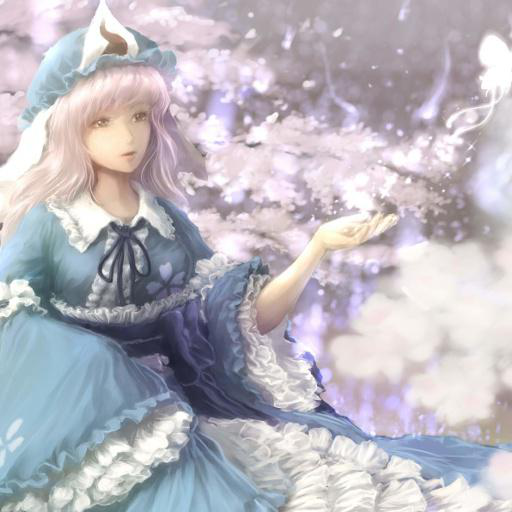

In [50]:
#Test PIL Open
pil_image = Image.open(img_path)
save_img(pil_img, 'tmp.jpg')
out_image = Image.open('tmp.jpg')
os.remove('tmp.jpg')
out_image

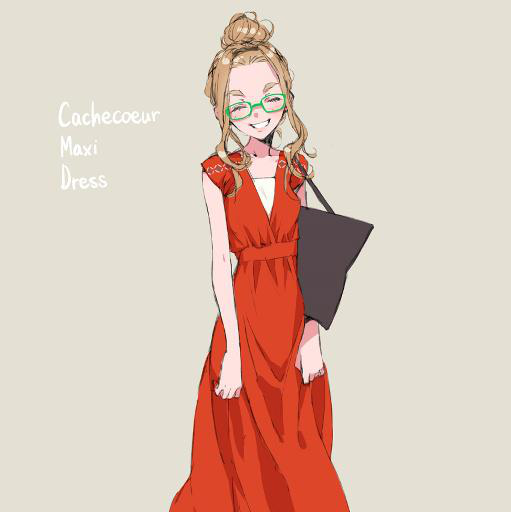

In [51]:
# Test Tensor Save 
pil_image = Image.open(img_path)
tensor = transforms.ToTensor()(pil_img)
save_255norm_tensor_img(tensor, 'norm_tensor_tmp.jpg')
out_image = Image.open('norm_tensor_tmp.jpg')
os.remove('norm_tensor_tmp.jpg')
out_image

uint8
<class 'numpy.ndarray'> None (512, 512, 3) 27 255 186.953927358 46.1747610795


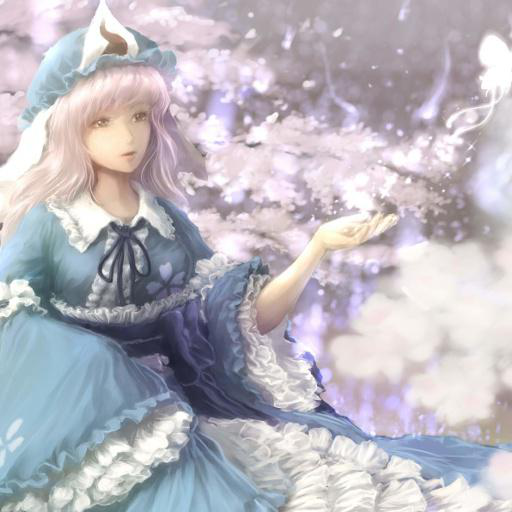

In [52]:
# Test Numpy Save (no normalization)
np_arr = load_img_as_np_arr(img_path)
print (type(np_arr), print(np_arr.dtype), np_arr.shape, np_arr.min(), np_arr.max(), np_arr.mean(), np_arr.std())
save_numpy_img(np_arr, 'np_tmp.jpg')
out_image = Image.open('np_tmp.jpg')
os.remove('np_tmp.jpg')
out_image

(512, 512)
uint8
<class 'numpy.ndarray'> None (512, 511, 3) 0 255 200.49754235 54.4740488574
<class 'numpy.ndarray'> float64 (512, 511, 3) 0.0 1.0 0.786264871959 0.213623721009


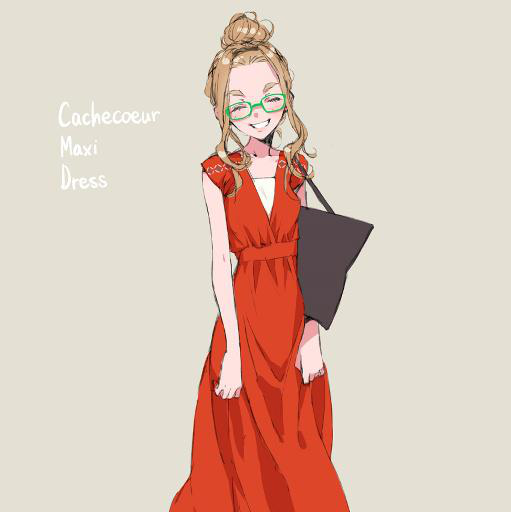

In [53]:
#Test Norm255 Numpy Save
pil_image = Image.open(img_path)
print(pil_image.size)
np_arr = np.array(pil_img)
print (type(np_arr), print(np_arr.dtype), np_arr.shape, np_arr.min(), np_arr.max(), np_arr.mean(), np_arr.std())
norm_np_arr = norm255_np_arr(np_arr)
print (type(norm_np_arr), norm_np_arr.dtype, norm_np_arr.shape,norm_np_arr.min(), norm_np_arr.max(),  norm_np_arr.mean(), norm_np_arr.std())
save_255norm_numpy_img(norm_np_arr, 'norm_np_tmp.jpg')
out_image = Image.open('norm_np_tmp.jpg')
os.remove('norm_np_tmp.jpg')
out_image

# Clip/Clamp

**Use Case**
During the neural style learning phace, the image pixels values produced by our generator fall be between $-\infty$ and $+\infty$ instead of staying between 0 and 1 (our desired normalized range). In other words, the image is well optimized, but has absurd values. In fact, we must perform an optimization under constraints in order to keep having right vaues into our input image. There is a simple solution: at each step, to correct the image to maintain its values into the 0-1 interval. So we use clipping/clampping.

In [57]:
def clip_tensor(t, min_val, max_val):
    """return new tensor w all values smaller than min_val
    set to min all values larger than max_val set to max"""
    return t.clamp(min_val,max_val)

def clip_numpy(np_arr, min_val, max_val):
    """return new numppy array w all values smaller than min_val
    set to min all values larger than max_val set to max"""
    return np_arr.clip(min_val, max_val)

# Inputs
t = torch.range(0,10)
print(t.view(1,-1))
n = np.arange(0,11)
print(n)

# Clip Tensor
ct = t.clamp(3,6)
print(ct.view(1,-1))

# Clip Numpy
cn = n.clip(3,6)
print(cn)


    0     1     2     3     4     5     6     7     8     9    10
[torch.FloatTensor of size 1x11]

[ 0  1  2  3  4  5  6  7  8  9 10]

    3     3     3     3     4     5     6     6     6     6     6
[torch.FloatTensor of size 1x11]

[3 3 3 3 4 5 6 6 6 6 6]


# Plot Images

In [58]:
img_path = get_random_image_path(IMAGES_PATH)

In [123]:
def plot_np_array(arr_img, fs=(3,3)):
    # fs == inches?)
    plt.figure(figsize=fs)
    plt.imshow(arr_img.astype('uint8'))
    plt.show()

def plot_tensor(tns_img, fs=(3,3)):
    "Takes a normalized tensor [0,1] and plots PIL image"
    pil_from_tns = transforms.ToPILImage()(tns_img)
    plt.figure(figsize=fs)
    plt.imshow(pil_from_tns)
    plt.show()

def plot_pil(pil_img, fs=(3,3)):
    plt.figure(figsize=fs)
    plt.imshow(pil_img)
    plt.show()

def plot_meanstd_normed_np_array(arr, mean, std):
    """If normalized with mean/std"""
    arr = denorm_meanstd(arr, mean, std)
    plot_np_array(arr)

def plot_meanstd_normed_tensor(tns, mean, std):
    """If normalized with mean/std"""
    tns = denorm_meanstd(tns, mean, std)
    plot_tensor(tns)
    
def plot_norm255_np_array(arr, fs=(3,3)):
    """If normalized with norm255"""
    arr = denorm255_np_arr(arr)
    plot_np_array(arr, fs)

<class 'PIL.JpegImagePlugin.JpegImageFile'> (512, 512)


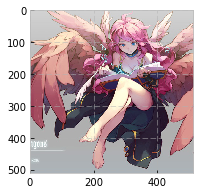

<class 'numpy.ndarray'> (512, 512, 3) 0 255 147.970769246 63.957022423


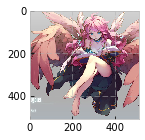

torch.Size([3, 512, 512])


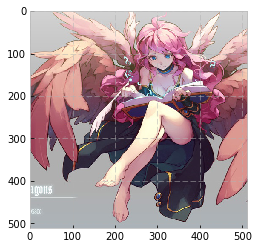

normalized numpy


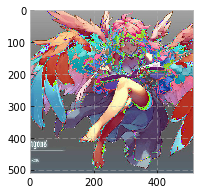

denormalized numpy


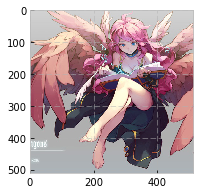

normalized tensor


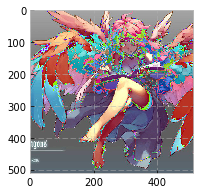

denormalized tensor


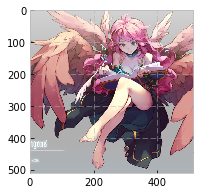

input numpy (512, 512, 3) 0 255 147.970769246 63.957022423
255norm numpy (512, 512, 3) 0.0 1.0 0.580277526457 0.250811852639 256


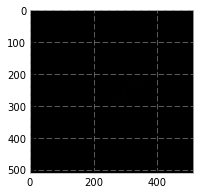

255denorm numpy


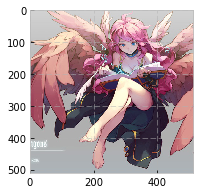

In [124]:
FAKE_MEAN = 0.5
FAKE_STD = 0.5

#Plot PIL
pil_img = Image.open(img_path)
print(type(pil_img), pil_img.size)
plot_pil(pil_img,(3,3))

#Plot Numpy Arrary
np_arr = np.array(pil_img)
print(type(np_arr), np_arr.shape, np_arr.min(), np_arr.max(), np_arr.mean(), np_arr.std())
plot_np_array(np_arr, (2,2))

#Plot Tensor
tns = transforms.ToTensor()(pil_img)
print(tns.size())
plot_tensor(tns, (4,4))

### Mean/Std ###

#Plot Mean/Std Normalized Numpy Array
norm_np_arr = norm_meanstd(np_arr, FAKE_MEAN, FAKE_STD)
print("normalized numpy")
plot_np_array(norm_np_arr)

#Plot Mean/Std Deormalized Numpy Array
print("denormalized numpy")
plot_meanstd_normed_np_array(norm_np_arr, FAKE_MEAN, FAKE_STD)

#Plot Mean/Std Normalized Tensor
norm_tensor = norm_meanstd(tns, FAKE_MEAN, FAKE_STD)
print("normalized tensor")
plot_tensor(norm_tensor)

#Plot Mean/Std Deormalized Tensor
print("denormalized tensor")
plot_meanstd_normed_tensor(norm_tensor, FAKE_MEAN, FAKE_STD)


### 255 ###

#Plot 255 Normalized Numpy Array (all black since pixels are close to 0)
norm_np_arr = norm255_np_arr(np_arr)
print("input numpy", np_arr.shape, np_arr.min(), np_arr.max(), np_arr.mean(), np_arr.std())
print("255norm numpy", norm_np_arr.shape, norm_np_arr.min(), norm_np_arr.max(), 
      norm_np_arr.mean(), norm_np_arr.std(), len(np.unique(norm_np_arr)))
plot_np_array(norm_np_arr)

#Plot 255 Deormalized Numpy Array
print("255denorm numpy")
plot_norm255_np_array(norm_np_arr)

# Image Grid

In [18]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

torch.Size([3, 768, 1024])


TypeError: Image data can not convert to float

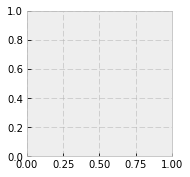

In [19]:
lena = scipy.misc.face()
img = transforms.ToTensor()(lena)
print(img.size())
imglist = [img, img, img, img.clone().fill_(-10)]
plots(imglist)

In [ ]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

#Currently Broken due to PyTorch Bug, will be fixed in next release
show_grid(torch_img_utils.make_grid(imglist, padding=100))

# Augmentation

Everything in both Numpy and Pytorch

* Center Crop
* Random Flips
* Random Crop
* Scale
* Padding
* Lambda function as input (Pytorch)

Links
* https://github.com/pytorch/vision/blob/master/torchvision/transforms.py

## Center Crop

### Numpy

In [65]:
def center_crop_2d(np_arr, size=(128,128)):
    """
    np_arr: = np array of how many dims?
    Size: = (rows, cols)"""
    rows, cols = np_arr.shape
    new_rows, new_cols = size
    
    start_row = (rows - new_rows) // 2
    start_col = (cols - new_cols) // 2
    end_row = start_row + new_rows
    end_col = start_col + new_cols
    return np_arr[start_row:end_row, start_col:end_col]

In [66]:
# Test 2D
inp = np.random.rand(5,5)
print("Input", inp.shape)
print(inp)

out = center_crop_2d(inp,(3,3))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(5,5))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(2,2))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(1,1))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(1,3))
print("Output", out.shape)
print(out)

out = center_crop_2d(inp,(3,2))
print("Output", out.shape)
print(out)

Input (5, 5)
[[ 0.61350717  0.2883485   0.34686171  0.43175649  0.63199441]
 [ 0.5519451   0.39177764  0.22172204  0.22021638  0.08646015]
 [ 0.62292324  0.10027065  0.10391734  0.70569636  0.46565653]
 [ 0.30226005  0.44284503  0.71964967  0.68340451  0.72487314]
 [ 0.91366503  0.54040642  0.93200114  0.39973762  0.1154669 ]]
Output (3, 3)
[[ 0.39177764  0.22172204  0.22021638]
 [ 0.10027065  0.10391734  0.70569636]
 [ 0.44284503  0.71964967  0.68340451]]
Output (5, 5)
[[ 0.61350717  0.2883485   0.34686171  0.43175649  0.63199441]
 [ 0.5519451   0.39177764  0.22172204  0.22021638  0.08646015]
 [ 0.62292324  0.10027065  0.10391734  0.70569636  0.46565653]
 [ 0.30226005  0.44284503  0.71964967  0.68340451  0.72487314]
 [ 0.91366503  0.54040642  0.93200114  0.39973762  0.1154669 ]]
Output (2, 2)
[[ 0.39177764  0.22172204]
 [ 0.10027065  0.10391734]]
Output (1, 1)
[[ 0.10391734]]
Output (1, 3)
[[ 0.10027065  0.10391734  0.70569636]]
Output (3, 2)
[[ 0.39177764  0.22172204]
 [ 0.10027065  

In [67]:
def center_crop_3d(np_arr, size=(128,128)):
    """
    np_arr: = np array of how many dims?
    Size: = (rows, cols)"""
    rows, cols, depth = np_arr.shape
    new_rows, new_cols = size
    
    start_row = (rows - new_rows) // 2
    start_col = (cols - new_cols) // 2
    end_row = start_row + new_rows
    end_col = start_col + new_cols
    return np_arr[start_row:end_row, start_col:end_col, :]

# Test 3D
inp = np.random.rand(5,5,3) #3rd is channels
print("Input", inp.shape)
print(inp)

out = center_crop_3d(inp,(3,3))
print("Output", out.shape)
print(out)

Input (5, 5, 3)
[[[ 0.88582292  0.40669002  0.38972529]
  [ 0.435507    0.89043078  0.37324079]
  [ 0.25059266  0.29329278  0.56363982]
  [ 0.70364159  0.89279939  0.67490292]
  [ 0.5634655   0.11857621  0.66175181]]

 [[ 0.51696393  0.8521019   0.4136245 ]
  [ 0.96423109  0.04542974  0.11041903]
  [ 0.09454149  0.1173645   0.36359123]
  [ 0.66350341  0.32277905  0.52658935]
  [ 0.93911292  0.29042521  0.21870343]]

 [[ 0.14637576  0.08232858  0.95045316]
  [ 0.62040449  0.3953178   0.50801305]
  [ 0.74459432  0.92378045  0.99954014]
  [ 0.16157123  0.81038933  0.69337357]
  [ 0.4904894   0.67020007  0.29394231]]

 [[ 0.23229267  0.02793036  0.75194269]
  [ 0.59529023  0.40279636  0.91640653]
  [ 0.32887456  0.25397772  0.06296361]
  [ 0.46007374  0.8365998   0.04064791]
  [ 0.2649131   0.95237895  0.99150746]]

 [[ 0.00641299  0.05549724  0.16091446]
  [ 0.84263499  0.49892383  0.66514472]
  [ 0.74291769  0.33373594  0.83688985]
  [ 0.09976493  0.65165409  0.49125177]
  [ 0.87608138  

### Pytorch

In [68]:
### TODO ###
tensor = torch.randn(3,10,10)
#transforms.CenterCrop(tensor, size=(3,3))

# Datasets

* Load Images from Directory
* Load Dataset from Pytorch Library (LSUN, MNIST, Pascal VOC) 

In [115]:
mean,std = get_mean_std_dataset(IMAGES_PATH)

#Dataset object with no transforms -- Holds Filenames, Class Names and Ids
dataset = datasets.ImageFolder(root=IMAGES_PATH, transform=None) 

#Dataset with complex transforms
dataset = datasets.ImageFolder(root=IMAGES_PATH, 
           transform=transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.RandomCrop(224),
            transforms.RandomSizedCrop(100), #https://github.com/pytorch/vision/blob/master/torchvision/transforms.py#L230
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(torch.FloatTensor(mean), 
                 torch.FloatTensor(std)),
        ]))

#Dataset with simplest transform
dataset = datasets.ImageFolder(root=IMAGES_PATH, 
           transform=transforms.Compose([
            transforms.ToTensor()
        ]))

mean: [ 214.86615829  199.72889175  189.61952591]
stdev: [ 59.79243763  67.59167723  72.80611973]


# Data Loaders

* Custom image loader in Numpy
* Image Loader in Pytorch (w transforms)

In [116]:
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True,
    num_workers=2, pin_memory=True)

In [119]:
# Get next batch - a list of tensors
batch = next(iter(train_loader))

2
torch.Size([5, 3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512]) 0.09019608050584793 1.0 0.7817805639675726 0.10985406074657719


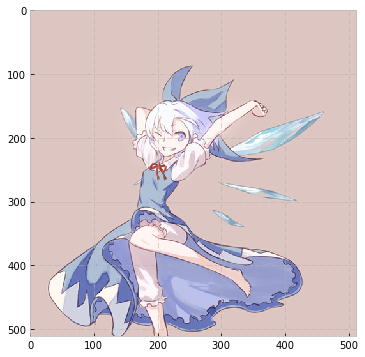

In [120]:
print (len(batch))
print (batch[0].size()) #batch_size, channels, height (rows), width (cols)
print (batch[0][0].size()) #first image

#First Image
tns_img = batch[0][0] #first image
print(tns_img.size(), tns_img.min(), tns_img.max(), tns_img.mean(), tns_img.std())
plot_tensor(batch[0][0], fs=(6,6)) #handles denormalizign and returning PIL

# Edge Detection

## Canny Edge Detector

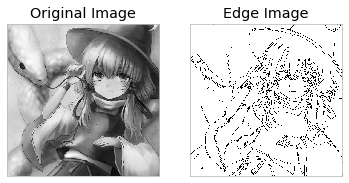

In [28]:
img_path = get_random_image_path(IMAGES_PATH)
img = cv2.imread(img_path,0)
edges = cv2.Canny(img,100,200)
edges = np.invert(edges)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Clean Edge Extractor

In [29]:
def extract_edge(imname, blur=False, median=False, bilateral=False):
    img = cv2.imread(imname,0)
    if img is None:
        return None

    if blur:
        img = cv2.GaussianBlur(img, (5, 5), 0) # Remove noise
    if median:
        img = cv2.medianBlur(img,5)
    if bilateral:
        img = cv2.bilateralFilter(img,9,75,75)

    img_edge = cv2.adaptiveThreshold(img, 255,
                                     cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY,
                                     blockSize=9,
                                     C=2)
    img_edge = cv2.cvtColor(img_edge, cv2.COLOR_GRAY2RGB)
    
    return img_edge

def extract_all(dir_path, edges_path):
    fpaths,fnames = get_paths_to_files(dir_path)
    for i in tqdm(range(len(fpaths))):
        edge = extract_edge(fpaths[i], median=True, blur=True)    
        if edge is not None:
            cv2.imwrite(edges_path+fnames[i]+"_edge.png", edge)
        else:
            print(fpaths[i] + " is None")

In [30]:
img_path = get_random_image_path(IMAGES_PATH)

In [31]:
plot_pil(Image.open(img_path),(6,6))
edge = extract_edge(img_path)
plot_np_array(edge)
edge = extract_edge(img_path, blur=True)
plot_np_array(edge)
edge = extract_edge(img_path, bilateral=True)
plot_np_array(edge)
edge = extract_edge(img_path, median=True)
plot_np_array(edge)
edge = extract_edge(img_path, bilateral=True, median=True)
plot_np_array(edge)
edge = extract_edge(img_path, bilateral=True, blur=True)
plot_np_array(edge)
edge = extract_edge(img_path, median=True, blur=True)  #best combo so far
plot_np_array(edge)

NameError: name 'plot_pil' is not defined

# Blob Detection

# Confusion Matrix

In [32]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Resources